In [4]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import sounddevice as sd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

ModuleNotFoundError: No module named 'sounddevice'

In [ ]:
def DFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [ ]:
def BM_H_win(x):
    N = x.shape[0]
    a0 = 0.3635819
    a1 = 0.4891775
    a2 = 0.1365995
    a3 = 0.0106411
    return a0 - a1*np.cos((2*np.pi*x)/N) + a2*np.cos((4*np.pi*x)/N) - a3*np.cos((6*np.pi*x)/N)

def sine_win(x):
    N = x.shape[0]
    return np.sin((np.pi*x)/N)

def D_cheb_win(x, a):
    N = x.shape[0]
    al = 10**a
    B = np.cosh((1/N) * np.arccosh(al))

    w = np.zeros(N)
    ind = 0
    for i in x:
        x_pol = B*np.cos((np.pi*i)/(N+1))
        
        if ((-1 <= x_pol) & (x_pol <= 1)):
            T = np.cos(N*(np.arccos(x_pol)))
        elif x_pol >= 1:
            T = np.cosh(N*np.arccosh(x_pol))
        elif x_pol <= -1:
            T = ((-1)**N)*np.cosh(N*np.arccosh(-x_pol))
        w[ind] = T/al
        ind = ind + 1

    return w


In [ ]:
def FFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + terms[:int(N/2)] * X_odd,
                               X_even + terms[int(N/2):] * X_odd])

0.05517319483912068


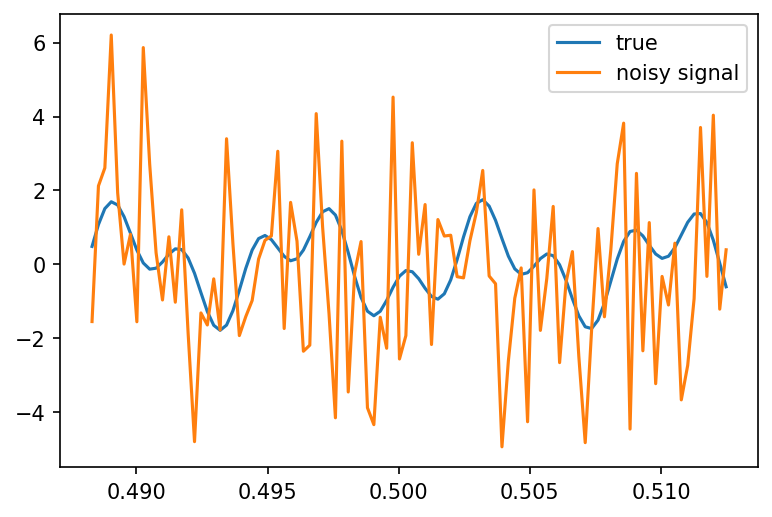

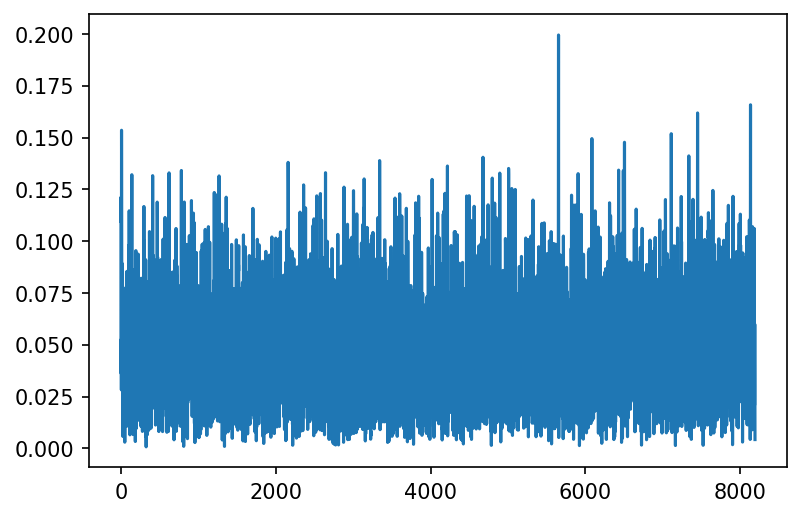

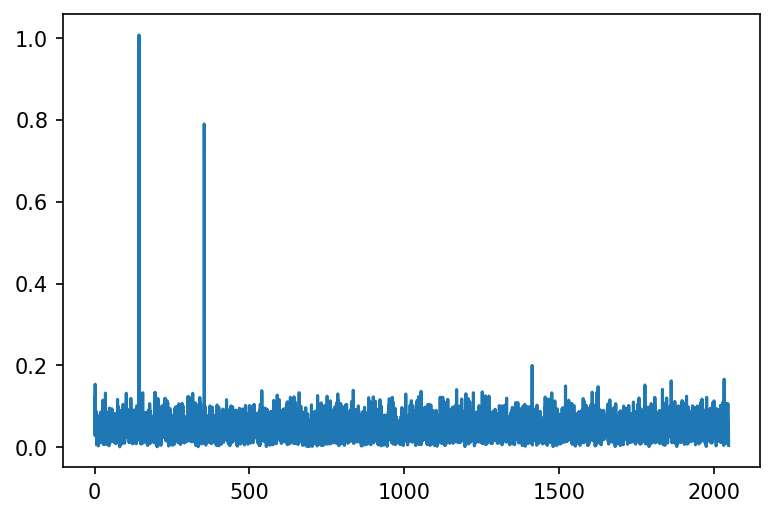

In [ ]:
fs = 4096
L = 4
t = np.linspace(0,L,fs*L)

noise = random.randn(fs*L)*2.5

f1 = 143.5
f2 = 354.3
s = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)*0.8
input = s + noise

win = BM_H_win(np.arange(L*fs))
out_full = FFT(input*win)
out = 2*np.abs(out_full)/(np.sum(win))
out = out[0: int(L*fs/2)]

noise_std = np.abs(2*np.std(FFT(noise*win))/np.sum(win))

fr = np.linspace(0,int(fs/2),int((L*fs)/2))
print(noise_std)

plt.plot(t[2000:2100], s[2000:2100], t[2000:2100], input[2000:2100])
plt.legend(['true', 'noisy signal'])
plt.show()
plt.plot((np.abs(2*FFT(noise*win)/np.sum(win)))[0:int((L*fs)/2)])
plt.show()
plt.plot(fr, out)

In [ ]:
def thresholding_algo(y, lag, threshold, influence):

    processedSig = y[0:lag]
    peakInd = np.asarray([])
    latestInd = 0
    for i in range(lag,y.shape[0],1):
        x = y[i]
        avg = np.average(processedSig[(i-lag): i])
        sd = np.std(processedSig[(i-lag):i])
        if (x - avg) > sd*threshold:
            if(latestInd == i-1):
                
                peakInd = peakInd
            else:
                latestInd = i
                peakInd = np.append(peakInd, i)
            processedSig = np.append(processedSig, x)
        else:
            latestInd = i
            processedSig = np.append(processedSig, x)


    return peakInd

    #return dict(signals = np.asarray(signals),
    #            avgFilter = np.asarray(avgFilter),
    #            stdFilter = np.asarray(stdFilter))

In [ ]:
def findPeak(x, thresh):
    lag = 500
    influence = 0.8
    return thresholding_algo(x, lag, thresh, influence)


In [ ]:
win = BM_H_win(np.arange(L*fs))
nspd = np.std(2*np.abs(FFT(noise*win)/(np.sum(win))))
print(nspd)

0.02533891445135065


In [ ]:
print(out.shape[0])
peaks = findPeak(out, 10)
print(peaks)

#print(fr[peaks >0])

#plt.plot(out)
#plt.plot(peaks)

8192
[ 574. 1417.]


In [ ]:
def build_filt(peaks, filt_len, fft_size):
    filt = np.zeros(int(fft_size/2))
    half_len = int(filt_len/2)
    for i in peaks:
        i = int(i)
        if (i+half_len) > filt.shape[0]:
            filt = filt
        elif i-half_len < 0:
            filt = filt
        else:
            filt[i-half_len: i+half_len] = BM_H_win(np.arange(filt_len))
    return np.concatenate((filt, np.flip(filt)), axis=0)

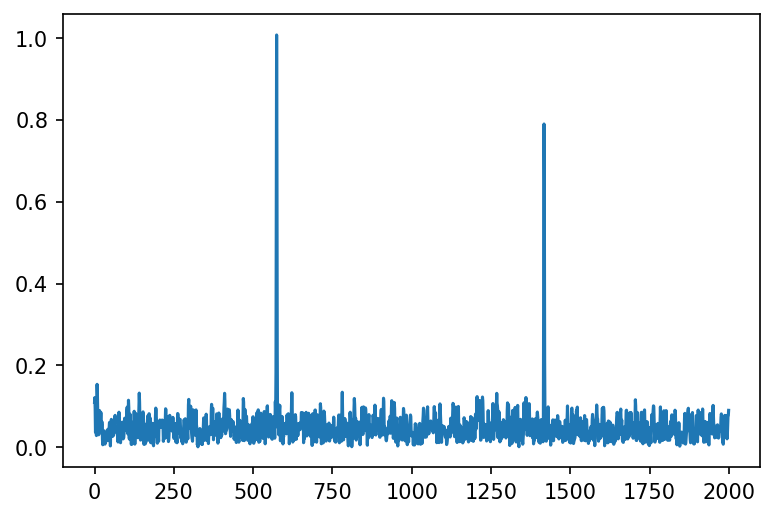

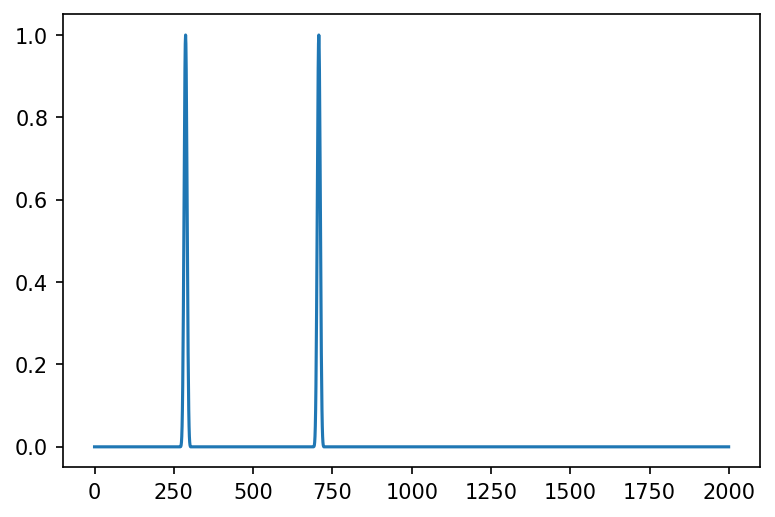

c:\Users\rytte\OneDrive\Dokument\GitHub\Algorithms\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


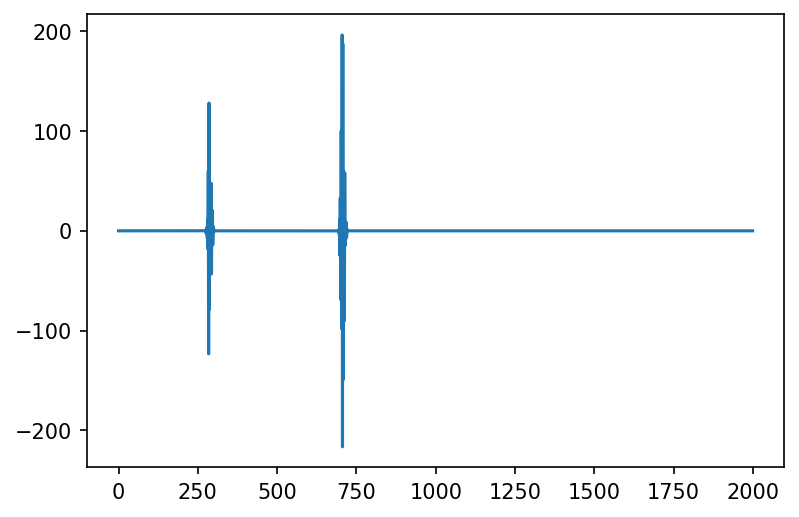

In [ ]:
#fp = peaks > 0
#freqPeaks = np.arange(fr.shape[0])[fp]

fw = build_filt(peaks, 2**5, L*fs)

plt.plot((2*np.abs(out_full)/(np.sum(win)))[0:2000])
plt.show()
plt.plot(fw[0:2000])
plt.show()

filtOut = out_full*fw
plt.plot(filtOut[0:2000])

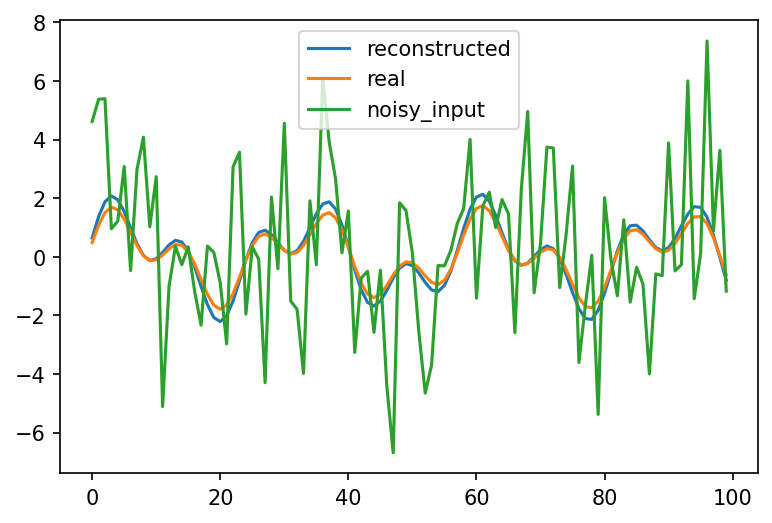

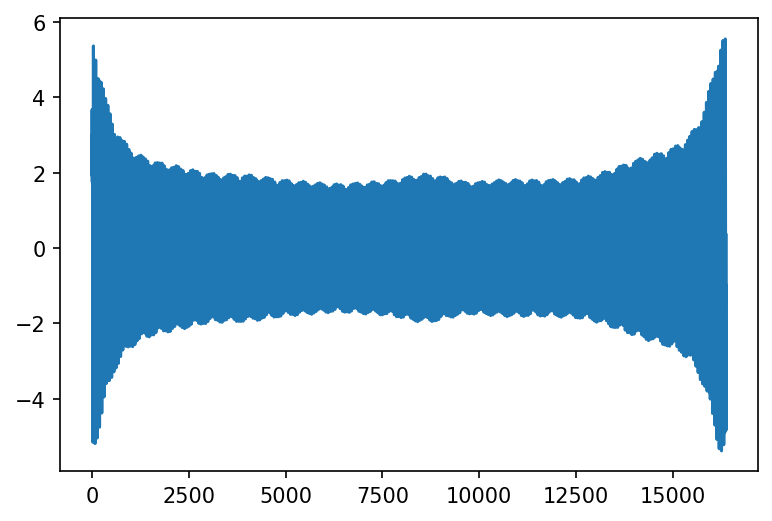

In [ ]:
rec_s = np.real(np.fft.ifft(filtOut)/(win))
plt.plot(rec_s[2000:2100])
plt.plot(s[2000:2100])
plt.plot(input[2000:2100])
plt.legend(['reconstructed', 'real', 'noisy_input'])
plt.show()
plt.plot(rec_s)

In [ ]:
sd.play(input, fs)

In [ ]:
sd.play(s, fs)

In [ ]:
sd.play(rec_s, fs)

In [ ]:
def crossFade(a,b,len):
    filt = np.linspace(0,1,len)
    a_len = a.shape[0]
    b_len = b.shape[0]
    a[a_len-len:] = a[a_len-len:]*np.flip(filt)
    b[0:len] = b[0:len]*filt
    out = np.zeros((a_len + b_len)-len)
    out[a_len-len:] = out[a_len-len:] + b
    out[0:a_len] = out[0:a_len] + a
    return out

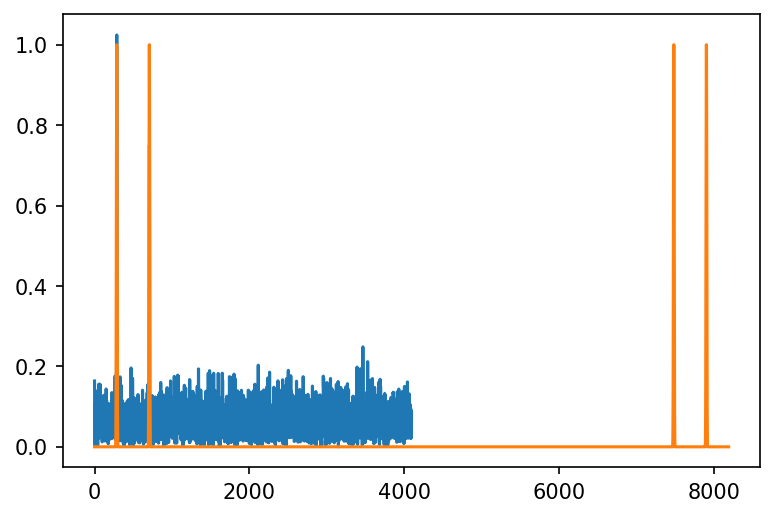

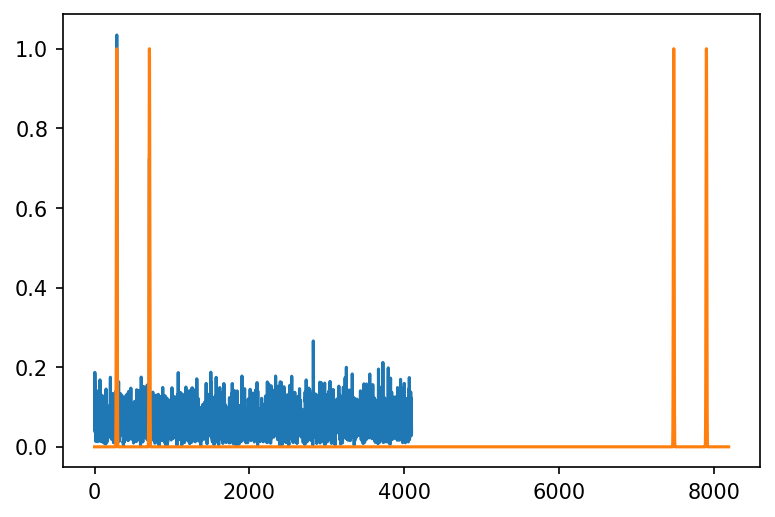

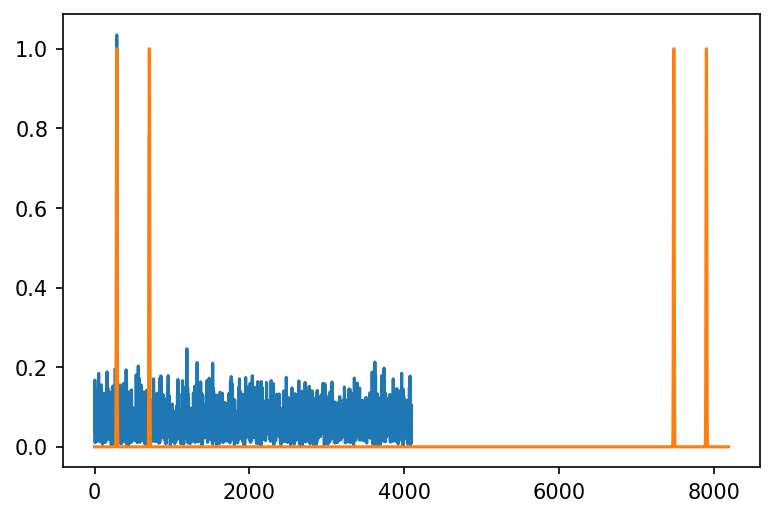

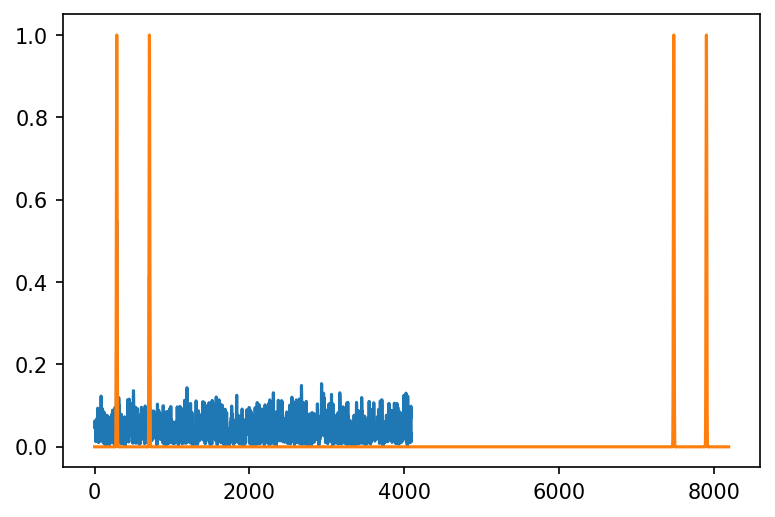

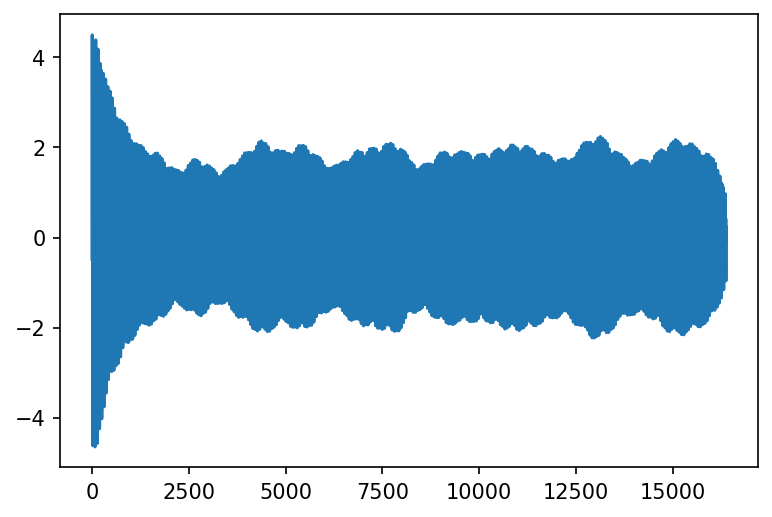

In [ ]:


filt_len = fs*2
rec_s_bit = np.zeros(filt_len)
win = BM_H_win(np.arange(filt_len))

input = np.concatenate((input, np.zeros(filt_len)), axis=0)

for i in range(4):
    fft_sig = FFT(input[(i*fs):(i*fs)+filt_len]*win)
    hfft_sig = 2*np.abs(fft_sig)/(np.sum(win))
    hfft_sig = hfft_sig[0: int(filt_len/2)]

    peaks = thresholding_algo(hfft_sig, 100, 6, 0)    
    fw = build_filt(peaks, 2**5, filt_len)
    plt.plot(hfft_sig)
    plt.plot(fw)
    plt.show()

    if(i > 0):
        rec_s_bit = crossFade(rec_s_bit, np.real(np.fft.ifft(fw*fft_sig)/(win)), fs)
    else:
        rec_s_bit[0:filt_len] = np.real(np.fft.ifft(fw*fft_sig)/(win))
        #rec_s_bit[(i*filt_len):(i*filt_len)+filt_len] = np.real(np.fft.ifft(fw*fft_sig)/(win))
plt.plot(rec_s_bit[0:L*fs])


In [ ]:
sd.play(rec_s_bit, fs)

c:\Users\rytte\OneDrive\Dokument\GitHub\Algorithms\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


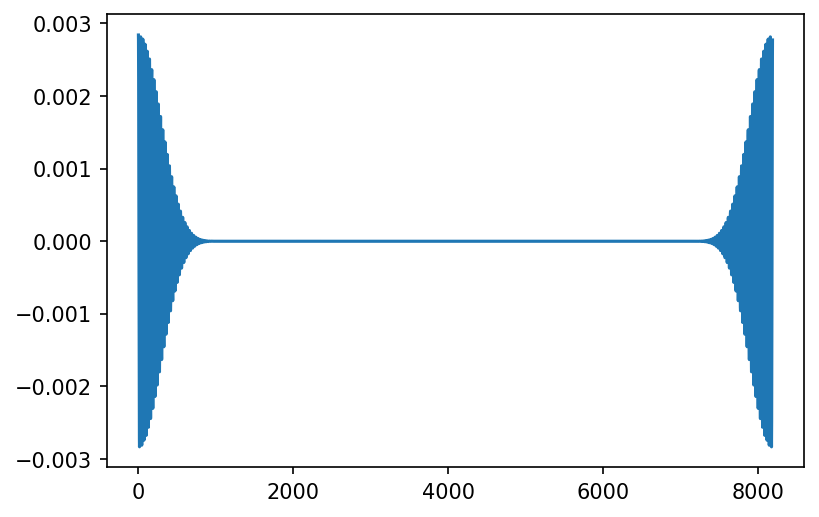

c:\Users\rytte\OneDrive\Dokument\GitHub\Algorithms\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


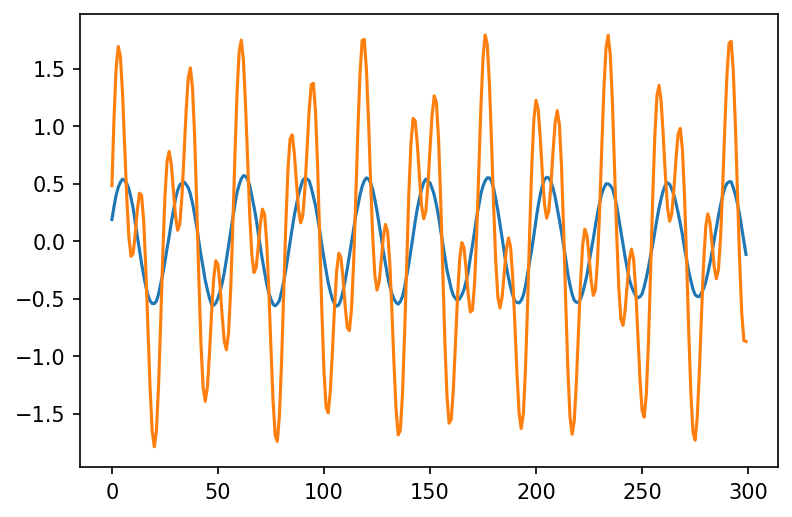

In [ ]:
#win_freq_resp = 2*np.abs(FFT(fw)/fw.shape[0])
win_freq_resp = np.fft.ifft(fw)

plt.plot(win_freq_resp)
plt.show()
plt.plot(np.convolve(win_freq_resp, input)[2000:2300])
plt.plot(s[2000:2300])

In [ ]:
from scipy.io import wavfile
samplerate, data = wavfile.read('./noisy_sig.wav')

C:\Users\rytte\AppData\Local\Temp/ipykernel_32044/2451878964.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('./noisy_sig.wav')


In [ ]:
sd.play(data, samplerate)

In [ ]:
print(samplerate)

In [ ]:
filt_len = samplerate*2
rec_s_bit = np.zeros(filt_len)
win = BM_H_win(np.arange(filt_len))

data = np.concatenate((data, np.zeros(filt_len)), axis=0)

for i in range(8):
    fft_sig = FFT(data[(i*fs):(i*fs)+filt_len]*win)
    hfft_sig = 2*np.abs(fft_sig)/(np.sum(win))
    hfft_sig = hfft_sig[0: int(filt_len/2)]

    peaks = thresholding_algo(hfft_sig, 100, 6, 0)    
    fw = build_filt(peaks, 2**5, filt_len)
    plt.plot(hfft_sig)
    plt.plot(fw)
    plt.show()

    if(i > 0):
        rec_s_bit = crossFade(rec_s_bit, np.real(np.fft.ifft(fw*fft_sig)/(win)), fs)
    else:
        rec_s_bit[0:filt_len] = np.real(np.fft.ifft(fw*fft_sig)/(win))
        #rec_s_bit[(i*filt_len):(i*filt_len)+filt_len] = np.real(np.fft.ifft(fw*fft_sig)/(win))
plt.plot(rec_s_bit[0:L*fs])

ValueError: must be a power of 2